# Feature View on Data Cubes

In the Earth observation domain, a coverage should be seen a thematic, spatio-temporal attribute of a feature, as it is also defined in the OGC General Feature Model (GFM). A coverage is attached to one (or more?) features as the surface of the Earth is attached to the Earth itself. A field, in most cases represented as coverage, e.g., colour, has no no-data values: it either exists or does not exist. In the broadest sense, a coverage, which covers the whole Earth is attached to the feature Earth; the colour variance within the continent Africa is attached to the feature Africa; the temperature variance of an agricultural field is attached to the agricultural field as a feature.

An example of a coverage (temperature) as an attribute of a feature (the Atlantic ocean) and the example definition of the General Feature Mode (from Wolf, Cox & Portele (2010):
![](res/coverage_as_feature_attribute.jpg)

Therefore, according to the General Feature Model, a coverage can be seen as a spatially varying attribute within a feature. In contrast, e.g., a name is a spatially non-varying attribute. There is a connection to spatially intrinsic properties (first case) and spatially extrinsic properties (second case). From Scheider & Huisjes (2018):

> In common understanding, originating in Physics and Chemistry, extensive properties increase with the size
of their supporting objects, while intensive properties are independent of this size

This means, for the Earth observation domain (Wolf, Cox & Portele (2010)):
> Both viewpoints are required since they each express a fundamental meta-model of the world: as a space populated by things, or as a space within which properties vary

%TODO: Temporal Domain: Processes, Events

## Use-case: Irrigated agriculture in Egypt with Sentinel-2

## Description

This example aims to identify agricultural fields in Egypt. The fields are maintained using a irrigation system, which is called ["center pivot irrigation"](https://en.m.wikipedia.org/wiki/Center_pivot_irrigation). A rotating sprinkler system generates the typical round areas: ![](https://upload.wikimedia.org/wikipedia/commons/1/17/PivotIrrigationOnCotton.jpg)

Satellite images can be used to document the extent and amount of the fields [as illustrated by this example using images from the Proba-V satellite](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba-v/image-of-the-week/-/article/pivot-irrigation-fields-egypt)

![](https://earth.esa.int/documents/10174/2555664/Proba-V-2014-2016-Pivot-Irrigation-Fields-Egypt-full.jpg)

Images from this area makes it a good testbed for Object-Based Image Analysis (OBIA) in data cubes:
- The resultion of Sentinel-2 is high enough to capture the fields and its details
- Images from this area are not frequently obscurred by clouds
- As shown in the example, the area is quite dynamic and allows to investigate temporal patterns.

This is a simple example, whichs serves as a first test.

## Steps to be completed prior to the analysis

For this example, make sure the file s2-workflow.sh was executed successfully, then import the datacube. The file sets up the data cube, indexes and ingests the provided Sentinel-2A Level 2 images.

In [16]:
%matplotlib inline
import datacube

## Loading data of the study area

Load the datacube and list the available product. The interesting ones are those having the name "s2a_sen2cor_granule", referring to the indexed Sentinel-2 Level 2 Bottom of Atmosphere (BOA) surface reflectance values, and "s2a_sen2cor_granule_ingested_10", referring to the ingested 10 m bands.

In [17]:
dc = datacube.Datacube()
dc.list_products()

,name,description,platform,label,time,format,instrument,lat,creation_time,lon,product_type,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
1,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,Sentinel-2A,None,None,JPEG2000,MSI,None,None,None,S2MSI1C,NaN,NaN,NaN,NaN
3,s2a_sen2cor_granule,Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...,SENTINEL_2A,None,None,JPEG2000,MSI,None,None,None,S2MSI2Ap,NaN,NaN,NaN,NaN
4,s2a_sen2cor_granule_ingested_10,Sentinel-2A MSI L2A 10 metre,SENTINEL_2A,None,None,NetCDF,MSI,None,None,None,S2MSI2Ap,EPSG:32635,"(-10, 10)","(100000.0, 100000.0)","(y, x)"
2,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,Sentinel-2B,None,None,JPEG2000,MSI,None,None,None,S2MSI1C,NaN,NaN,NaN,NaN


Load subset of the data cube, which will be referred to as "study area" below. The successful loading of the study area will be indicated by a Dataset type of the xarray module with 1 temporal and two spatial dimensions, whose length is larger than 1 (in space) and larger than 0 (in time). The values are of the type int16 and are not "Nan". The spatial reference system is the original UTM zone with EPSG Code 32635.

In [18]:
study_area = dc.load(
    product = 's2a_sen2cor_granule_ingested_10',
    x = (661741, 693067),
    y = (2449603,2465032),
    crs = 'EPSG:32635')

print(study_area)

<xarray.Dataset>
Dimensions:  (time: 1, x: 3133, y: 1544)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-09T08:50:22.975000
  * y        (y) float64 2.465e+06 2.465e+06 2.465e+06 2.465e+06 2.465e+06 ...
  * x        (x) float64 6.617e+05 6.618e+05 6.618e+05 6.618e+05 6.618e+05 ...
Data variables:
    blue     (time, y, x) int16 1937 1883 1910 1920 1949 1967 1925 1926 1958 ...
    green    (time, y, x) int16 3212 3218 3305 3286 3276 3278 3216 3237 3268 ...
    red      (time, y, x) int16 4844 4790 4914 4904 4973 4930 4806 4800 4830 ...
    nir      (time, y, x) int16 5546 5450 5628 5588 5639 5633 5547 5505 5543 ...
Attributes:
    crs:      EPSG:32635


Calculate the NDVI. The NDVI (Normalized Difference Vegetation Index) can be used to identify the health status of vegetation through the difference of reflection in red and near infrared bands. This is determined by the water content within the cells of the plants, which is a proxy of the health. The NDVI is often used to discriminate between vegetation and non-vegetation by assuming high NDVI values indicate presence of vegetation and low values indicate absence of vegetation. Although, this is not always reliable because other factors can generate high NDVI values as well, it is used in this example:

In [19]:
nir = study_area.nir
red = study_area.red
ndvi = ((nir - red) / (nir + red))

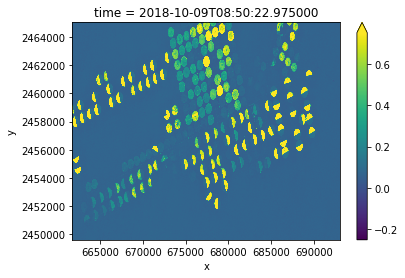

In [20]:
ndvi.plot(vmin=-0.25, vmax=0.75)

## Putting on the glasses with the feature view

### Background

Herman Minkovski gave a speech in 1906 Leipzig, Germany about the nature of space and time, which can be freely accessed [here (in german)](https://de.wikisource.org/wiki/Raum_und_Zeit_(Minkowski)). He defines a point in a 3D-space and 1D-time as a "world-point" (Weltpunkt) in a reference system "world" (Welt). This serves as an axiom, the smallest observable unit.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/De_Raum_zeit_Minkowski_Bild.jpg/450px-De_Raum_zeit_Minkowski_Bild.jpg)

Later, Goodchild, Yuan & Cova (2007) used a similar concept, which they call geo-atom.

> A geo-atom is defined as an association between a point location in space–time and a property.

The geo-atom can be written as a tuple <x,Z,z(x)> where x is the position in space and time ("world-point"), Z a property type (e.g., colour or temperature) and z(x) the value of the property type at the space-time-position. In this approach, the geo-atom is used to implement the measurement in a data cube and "bind" different geo-atoms together to either create a feature-view (objects) or a coverage-view (field). This is in-line with the notion of geo-object and geo-field in Goodchild, Yuan & Cova (2007):


The feature-view:
> A geo-object [here: feature] is defined as an aggregation of points in space–time whose geo-atoms meet certain requirements, such as having specified values for certain properties

The coverage-view:
>A geo-field [here: coverage] defines the variation of one or more properties over a domain of space–time D

In other words, we use the same atoms, (here: smallest observed, not necessarily observable unit) with different bindings to create both features and a coverage. This is a main idea behind rhino.

In [6]:
from rhino import rhino

### Defining the domain

Remember that a coverage is actually an attribute of a feature, where the attribute is spatially and temporally variable within the domain D of the feature. In most cases, the feature will be there, e.g., as area-of-interest, the shape of the study area, or a administrative entity such as a country. In this case, we create an artificial domain, but it is not rectangular, as indicated with the red polygon:

![](res/study_area.jpg)

The coordinates of the polygon are as follows:

In [7]:
wkt_polygon = """
    Polygon ((
        676807.47897574095986784 2453946.54447439312934875,
        678498.89029649586882442 2454515.2086253366433084,
        678630.1204851750517264 2454806.83126684604212642,
        678440.56576819391921163 2455433.81994609115645289,
        679315.433692722232081 2455798.34824797790497541,
        678673.86388140148483217 2457737.63881401577964425,
        678425.9846361184027046 2458014.68032344989478588,
        678003.13180592970456928 2459356.14447439322248101,
        674926.51293800503481179 2458335.46522911032661796,
        675305.62237196729984134 2456789.8652291102334857,
        675582.66388140129856765 2456571.14824797818437219,
        675888.8676549862138927 2456614.89164420450106263,
        676807.47897574095986784 2453946.54447439312934875))
    """

The domain is defined using the OGC WKT and can be of any shape.

In [8]:
domain = {
    "geometry": wkt_polygon,
    "crs":'EPSG:32635'
}

### Defining the property

Set the property we want to analyse, in this case the NDVI. Since we want to analyse vegetation vs. non-vegetation, we can define atoms with vegetation as similar and implement it by selecting atoms with values greater than 0.2.

In [9]:
atom_property = rhino.Property("ndvi")
atom_property.setSimilarityFunction(
    {
        "property":"avg(ndvi)",
        "value":0.2,
        "operator": "gt"
    })

### Defining the neighbourhood

Setting the neighborhood definition, which is used to find the aggregation to bind atoms to a feature. In this case, it is just a dummy and uses a traditional 4-connected neighbourhood in a matrix.

The neighbourhood is a concept within rhino, which is used by the engine to determine whether two features are neighbours or not. It does not necessarily mean that they have to be neighbours in a traditional sense, more complex relationships can be expressed as well, e.g., cloud / cloud-shadow.

In [10]:
neighbourhood = rhino.Neighbourhood()
print(neighbourhood.getConcept())

4-connected


### Example 1: Count features

Consider the question, which is conceptually impossible to solve in a coverage-based view: How many irrigated agricultural fields are within this area and how many of them are fully used and how many are only partially used?

We can solve this by using the feature-based view in rhino.

Load the data cube, this can take a while. In the first step, it simply forwards the load to the ODC datacube, in the second step, it creates the atoms and binds them to a coverage and objects.

In [11]:
dc = rhino.Datacube(show_progress = False, atom_property=atom_property)

dc.load(
    product = "s2a_sen2cor_granule_ingested_10",
    domain = domain
)

At this step, atoms cannot be easily manipulated any more as now a coverage-view and a feature-view exists, sharing the same atoms. The different views just bind them differently. In other words, the feature-view in this stage already exist, but each atom creates its indivdual object - or each object consists of only one atom. 

However, the result of the aggregation process (binding atoms from different features to a new feature) is a new feature-view and coverage-view. Note, that we do not need parameters as we have defined a property-similarity-function and a neighbourhood-definition-function.

In [12]:
features, coverage, level = dc.execute("aggregation", level = 0)

Plotting the coverage view gives us the NDVI values (remember: "variation of one or more properties") within the domain D.

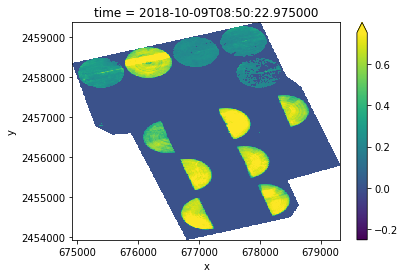

In [10]:
coverage.getStupidArray().plot(vmin=-0.25, vmax=0.75)

Since we also have access to the feature view, we can simply ask how many features were detected

In [13]:
print("Number of features: " + str(len(features)))

Number of features: 46


We can answer the first part of the question as the algorithm found 46 features respecting our definition of similarity and neighbourhood. Disclaimer: The Number is obviously too high as some smaller objects are still included. 

A post-processing using the gestalt-principle is not yet implemented, however, it is possible to select features according to their area.

Let's have a look at some extrinsic attributes of the features, the area and the compactness:

In [14]:
from geojson import Feature, Polygon, FeatureCollection
geojson_features = []
for i, feat in enumerate(features):
    geojson_features.append(
        Feature(
            geometry=feat.getGeometry(),
            properties={
                "compactness": feat.getAttributeValue('compactness'),
                "area": feat.getAttributeValue('area')}))

In [15]:
import geopandas as gp
geo_data_frame = gp.GeoDataFrame.from_features(geojson_features)

Plotting the area attributes shows the expected outcome that full-circles have a larger area than half-circles, if we neglect the swiss-cheese-effect, the salt-and-pepper-effect. In other cases, we might have to consider if features crossing the border of the domain D, which is not the case here.

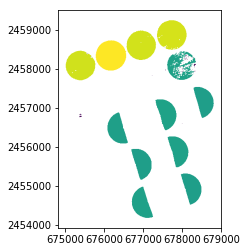

In [13]:
geo_data_frame.plot(column="area")

A look at the histogram of the areas reveals that there are a small number of very small objects, which we want to exclude:

(array([34.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  4.]),
 array([7.82403387e+01, 4.75310105e+04, 9.49837806e+04, 1.42436551e+05,
        1.89889321e+05, 2.37342091e+05, 2.84794861e+05, 3.32247631e+05,
        3.79700401e+05, 4.27153171e+05, 4.74605942e+05]),
 <a list of 10 Patch objects>)

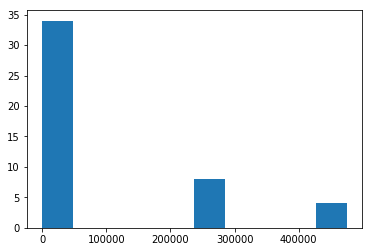

In [43]:
import numpy
areas = numpy.array([])
for feat in features:
    areas = numpy.append(areas, feat.getAttributeValue("area"))
    
from matplotlib import pyplot
pyplot.hist(areas)

We can use the selection to exclude the very small objects

In [45]:
features, coverage, level = dc.execute("selection", parameters = {"property": "area", "value": 200000, "operator": "gt"}, level= level["depth"])

The number of features in our domain is now 12 ...

In [50]:
print(len(features))

12


... and we can plot it again with the reduced set of objects

In [84]:
geojson_features = []
for i, feat in enumerate(features):
    geojson_features.append(
        Feature(
            geometry=feat.getGeometry(),
            properties={
                "compactness": feat.getAttributeValue('compactness'),
                "area": feat.getAttributeValue('area')}))
geo_data_frame = gp.GeoDataFrame.from_features(geojson_features)

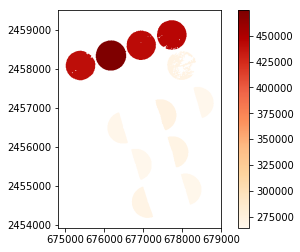

In [85]:
geo_data_frame.plot(column="area", cmap='OrRd', legend=True)

And also plot the compactness

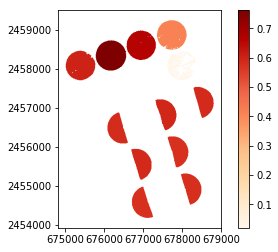

In [83]:
geo_data_frame.plot(column="compactness", cmap='OrRd', legend=True)

## Example 2: Exploring coverages as thematic attribute of features

When we refer to the General Feature Model, each of the features spans up its own spatio-temporal domain D with a (spatio-temporal) variation of the property, this means, the NDVI coverage becomes implicitly a thematic attribute of the feature.

For now, we keep the same definition of property and neighbourhood and have a look at the ndvi value-distribution within the features. Since there is no single NDVI value attached to a feature, there is no other way than treating it as a coverage and this type of visualisation needs some type of aggregation.

In [73]:
geojson_features = []
for i, feat in enumerate(features):
    geojson_features.append(
        Feature(
            geometry = feat.getGeometry(),
            properties = 
            {
                "compactness": feat.getAttributeValue('compactness'),
                "area": feat.getAttributeValue('area'),
                "avg_ndvi": feat.getAttributeValue('avg(ndvi)'),
                "std_ndvi": feat.getAttributeValue('std(ndvi)'),
                "min_ndvi": feat.getAttributeValue('min(ndvi)'),
                "max_ndvi": feat.getAttributeValue('max(ndvi)')
             }))
geo_data_frame = gp.GeoDataFrame.from_features(geojson_features)

Plotting the average NDVI values for each feature

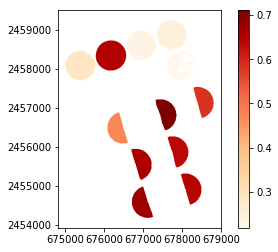

In [82]:
geo_data_frame.plot(column="avg_ndvi", cmap='OrRd', legend=True)

Plotting the minimum and maximum NDVI value

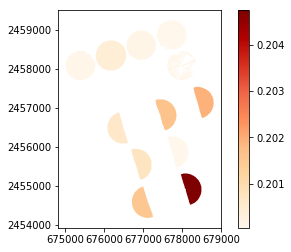

In [80]:
geo_data_frame.plot(column="min_ndvi", cmap='OrRd', legend=True)

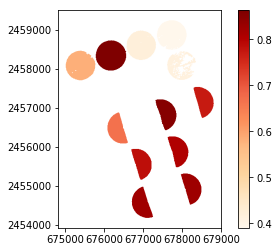

In [79]:
geo_data_frame.plot(column="max_ndvi", cmap='OrRd', legend=True)

Plotting the standard deviation of the NDVI values for each feature

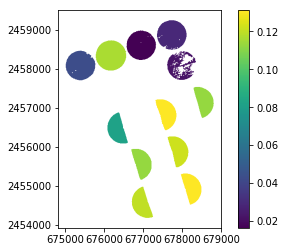

In [81]:
geo_data_frame.plot(column="std_ndvi", legend=True)

It is also possible to plot the histogram of the NDVI values, e.g., for the first feature

(array([ 705., 1369., 1091.,  636.,  340.,  169.,   83.,   37.,   14.,
           3.]),
 array([0.20004949, 0.21910544, 0.2381614 , 0.25721736, 0.27627331,
        0.29532927, 0.31438523, 0.33344118, 0.35249714, 0.37155309,
        0.39060905]),
 <a list of 10 Patch objects>)

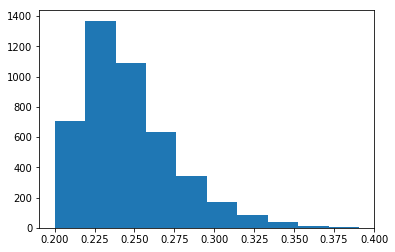

In [57]:
import numpy as np
from matplotlib import pyplot

atoms = features[0].getAtoms()
values = np.array([])
for atom in atoms:
    values = np.append(values,atom.getObservationValue())
pyplot.hist(values)


### Example 3: Exploring temporal patterns